<a href="https://colab.research.google.com/github/rafaellopezgarcia/colab_notebooks/blob/main/Wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
from google.colab import drive

drive.mount('/content/drive')
FOLDERNAME = "neural_networks/"
FILENAME = "names.txt"
PATH = "/content/drive/My Drive/" + FOLDERNAME + FILENAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
words = open(PATH, 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [36]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [100]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

#build the dataset
block_size = 8

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [101]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [102]:

# ------------------------------------------------------------------------------
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weights
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with packprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True)

    else:
      xmean = self.running_mean
      xvar =  self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum* xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# ------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  def parameters(self):
    return [self.weight]

# ------------------------------------------------------------------------------
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# ------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [103]:
torch.manual_seed(42); # seed rng for reproducibility

In [104]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
  layers[-1].weights *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

22097


In [111]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # lets look at the batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb) # (batch_size, block_size)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 11,  5],
        [ 0,  0, 16, 18,  1,  7,  1, 20],
        [ 0,  0,  0,  0,  0,  0, 13, 21]])

In [112]:
model.layers[0].out.shape # output of Embedding layer (batch_size, block_size, n_embd)

torch.Size([4, 8, 10])

In [113]:
model.layers[1].out.shape # output of Flatten layer (batch_size, block_size * n_embd )

torch.Size([4, 80])

In [114]:
model.layers[2].out.shape # Output of Linear layer

torch.Size([4, 200])

In [116]:
#Broadcasting performs matrix multiplication over the last dimension
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 5, 2, 200])

In [ ]:
# (1 2) (3 4) (5 6) (7 8)


In [105]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.5423
  10000/ 200000: 2.3569
  20000/ 200000: 2.5643
  30000/ 200000: 1.9939
  40000/ 200000: 2.3903
  50000/ 200000: 2.1886
  60000/ 200000: 2.0404
  70000/ 200000: 2.0652
  80000/ 200000: 2.0526
  90000/ 200000: 1.6401
 100000/ 200000: 1.9388
 110000/ 200000: 1.8740
 120000/ 200000: 1.8690
 130000/ 200000: 2.1222
 140000/ 200000: 2.0343
 150000/ 200000: 2.0136
 160000/ 200000: 1.6879
 170000/ 200000: 1.8373
 180000/ 200000: 1.6786
 190000/ 200000: 1.9821


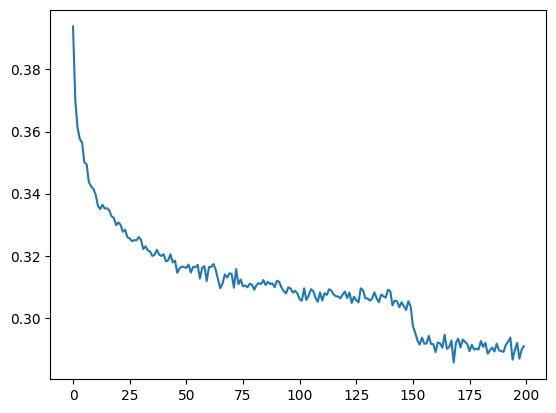

In [106]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [107]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [108]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9220343828201294
val 2.0287797451019287


In [109]:
# sample from the model
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    #forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track teh samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix ==0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated word

yevaugi.
kra.
kylek.
kisir.
zabriaus.
jiandre.
graycen.
aziel.
jifti.
keavan.
lebe.
kenthon.
eveny.
avionia.
harleon.
jass.
josuman.
kamia.
hendis.
delvany.
